In [17]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

print("All libraries imported successfully.")

All libraries imported successfully.


Synthetic data generated:
   cpu_utilization           timestamp
0        46.790664 1970-01-01 00:00:00
1        52.055407 1970-01-01 00:01:00
2        52.337499 1970-01-01 00:02:00
3        57.895968 1970-01-01 00:03:00
4        58.205776 1970-01-01 00:04:00


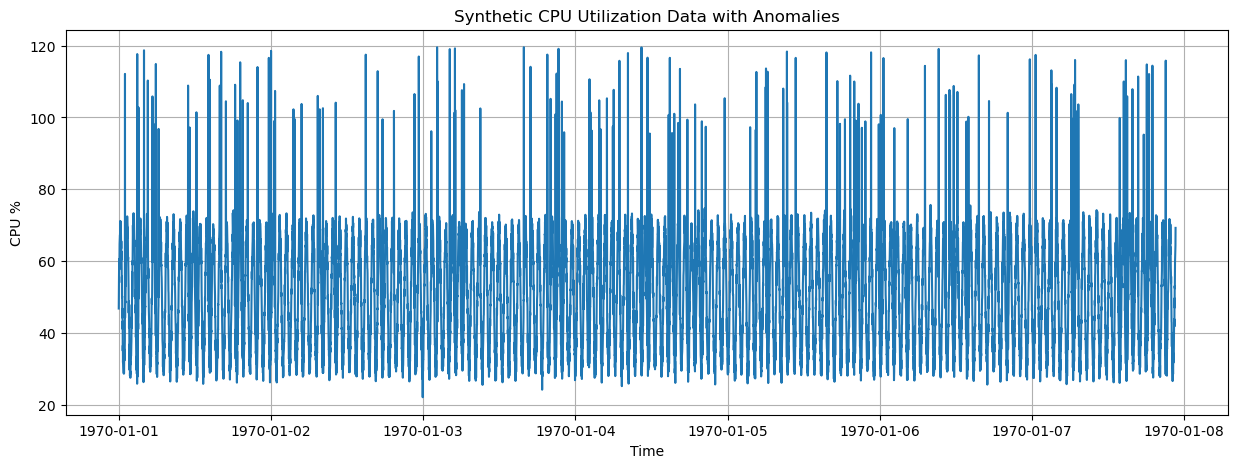

In [20]:
def generate_synthetic_data(points=10000, anomalies=150):
    """Generates a time series with normal behavior and some anomalies."""
    # Normal behavior: a sine wave with some noise
    time = np.arange(points)
    normal_data = 20 * np.sin(time * 0.1) + np.random.normal(0, 2, points) + 50

    # Inject some anomalies
    anomaly_indices = np.random.randint(0, points, size=anomalies)
    anomaly_values = np.random.uniform(95, 120, size=anomalies)
    normal_data[anomaly_indices] = anomaly_values

    df = pd.DataFrame(normal_data, columns=['cpu_utilization'])
    df['timestamp'] = pd.to_datetime(pd.Series(time), unit='m')
    return df

# Create and visualize the data
df = generate_synthetic_data()
print("Synthetic data generated:")
print(df.head())

# Plot the data to see what it looks like
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['cpu_utilization'])
plt.title('Synthetic CPU Utilization Data with Anomalies')
plt.ylabel('CPU %')
plt.xlabel('Time')
plt.grid(True)
plt.show()

In [21]:
# Create a dummy label column (all zeros) as the first column
df['dummy_label'] = 0 # <-- FIX: Add a dummy column for the label.

# IMPORTANT: Save the columns in the correct order: [label, feature]
train_csv_path = 'train_data.csv'
# <-- FIX: Save both columns to the CSV.
df[['dummy_label', 'cpu_utilization']].to_csv(train_csv_path, header=False, index=False)

print(f"Data with 2 columns saved to {train_csv_path}")

# Get your SageMaker session and S3 bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket() 
prefix = 'opsflow-anomaly-detection' # A folder in your S3 bucket

# Re-upload the newly formatted data
s3_uri = sagemaker_session.upload_data(path=train_csv_path, bucket=bucket, key_prefix=prefix)
print(f"Correctly formatted data successfully uploaded to: {s3_uri}")

Data with 2 columns saved to train_data.csv
Correctly formatted data successfully uploaded to: s3://sagemaker-ap-south-1-712672311489/opsflow-anomaly-detection/train_data.csv


In [22]:
from sagemaker.inputs import TrainingInput

# Get the execution role for this notebook
role = sagemaker.get_execution_role()
output_location = f's3://{bucket}/{prefix}/output'

# <-- FIX: Get the specific Docker container for the algorithm. This is the most reliable method.
image_uri = sagemaker.image_uris.retrieve(
    framework="randomcutforest",
    region=sagemaker_session.boto_region_name,
    version="1"
)

# <-- FIX: Use the generic sagemaker.estimator.Estimator, not the specialized one.
rcf_estimator = sagemaker.estimator.Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=output_location,
    sagemaker_session=sagemaker_session,
    # <-- FIX: Pass algorithm settings directly as hyperparameters.
    hyperparameters={
        'num_trees': 50,
        'num_samples_per_tree': 512,
        'feature_dim': 1  # This is still required.
    }
)

# <-- FIX: Create a TrainingInput object with the required data distribution type.
train_input = TrainingInput(
    s3_data=s3_uri,
    content_type='text/csv',
    distribution='ShardedByS3Key'
)

# This command will start the training job.
rcf_estimator.fit({'train': train_input})

print("\nTraining job completed successfully!")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: randomcutforest-2025-10-14-17-01-13-207


2025-10-14 17:01:14 Starting - Starting the training job...
2025-10-14 17:01:27 Starting - Preparing the instances for training...
2025-10-14 17:01:51 Downloading - Downloading input data...
2025-10-14 17:02:31 Downloading - Downloading the training image.........
2025-10-14 17:04:18 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[10/14/2025 17:04:22 INFO 139805675788096] Reading default configuration fr

In [23]:
# Deploy the trained model to an endpoint
# The endpoint name must be unique, so we add a timestamp.
from time import strftime, gmtime
endpoint_name = "opsflow-anomaly-detector-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(f"Deploying to endpoint: {endpoint_name}")

# Use a cost-effective instance for hosting the endpoint
rcf_predictor = rcf_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name=endpoint_name
)

print(f"\nEndpoint '{endpoint_name}' is now live and ready for predictions.")

INFO:sagemaker:Creating model with name: randomcutforest-2025-10-14-17-06-21-011


Deploying to endpoint: opsflow-anomaly-detector-2025-10-14-17-06-21


INFO:sagemaker:Creating endpoint-config with name opsflow-anomaly-detector-2025-10-14-17-06-21
INFO:sagemaker:Creating endpoint with name opsflow-anomaly-detector-2025-10-14-17-06-21


--------!
Endpoint 'opsflow-anomaly-detector-2025-10-14-17-06-21' is now live and ready for predictions.


In [28]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from time import strftime, gmtime

# --- 1. DEPLOY THE ENDPOINT (if it's not already running) ---
# This name must be unique. We'll create a new one.
endpoint_name = "opsflow-anomaly-detector-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(f"Deploying to a new permanent endpoint: {endpoint_name}")

rcf_predictor = rcf_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name=endpoint_name
)
print(f"\nEndpoint '{endpoint_name}' is now live and ready.")


# --- 2. CONFIGURE THE PREDICTOR ---
csv_predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer()
)

# --- 3. RUN A QUICK TEST TO CONFIRM IT WORKS ---
print("\n--- Running a quick validation test ---")
test_result = csv_predictor.predict([110.0])
score = test_result['scores'][0]['score']
print(f"Test on anomalous point [110.0] returned score: {score}")

if score > 1.0:
    print("Validation successful!")
else:
    print("Validation may have failed. Please check the score.")

# --- 4. LEAVE THE ENDPOINT RUNNING ---
# We have commented out the cleanup step so the endpoint stays active.
# print(f"\nDeleting endpoint: {endpoint_name}...")
# csv_predictor.delete_endpoint()
# print("Endpoint deleted successfully.")

INFO:sagemaker:Creating model with name: randomcutforest-2025-10-14-17-24-31-408


Deploying to a new permanent endpoint: opsflow-anomaly-detector-2025-10-14-17-24-31


INFO:sagemaker:Creating endpoint-config with name opsflow-anomaly-detector-2025-10-14-17-24-31
INFO:sagemaker:Creating endpoint with name opsflow-anomaly-detector-2025-10-14-17-24-31


--------!
Endpoint 'opsflow-anomaly-detector-2025-10-14-17-24-31' is now live and ready.

--- Running a quick validation test ---
Test on anomalous point [110.0] returned score: 2.5571893458
Validation successful!
